In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

Config.py creating local data directory /mnt/disks/disk-1/data/resnet50


In [21]:
batch_size = 256
model_name = 'upsampled'

In [22]:
train = pd.read_csv(os.path.join(cfg.csv_dir, 'train_upsampled_multilabel.csv'))
validation = pd.read_csv(os.path.join(cfg.csv_dir, 'validation_multilabel.csv'))
train['imagename'] = train['imagename'].map(lambda x: f"train/{x}")
validation['imagename'] = validation['imagename'].map(lambda x: f"validation/{x}")
df = pd.concat([train, validation])
df.reset_index(inplace=True, drop=True)

assert df.shape[0] == train.shape[0] + validation.shape[0]

In [23]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [24]:
src = (ImageList.from_df(path=cfg.img_path, df=df)
       .split_by_idx(valid_idx=range(train.shape[0], df.shape[0]))
       .label_from_df(cols='label', label_delim=' '))

In [25]:
data = (src.transform(tfms, size=224)
        .databunch(bs=batch_size).normalize(imagenet_stats))

In [26]:
assert len(data.valid_ds) == validation.shape[0]
assert len(data.train_ds) == train.shape[0]

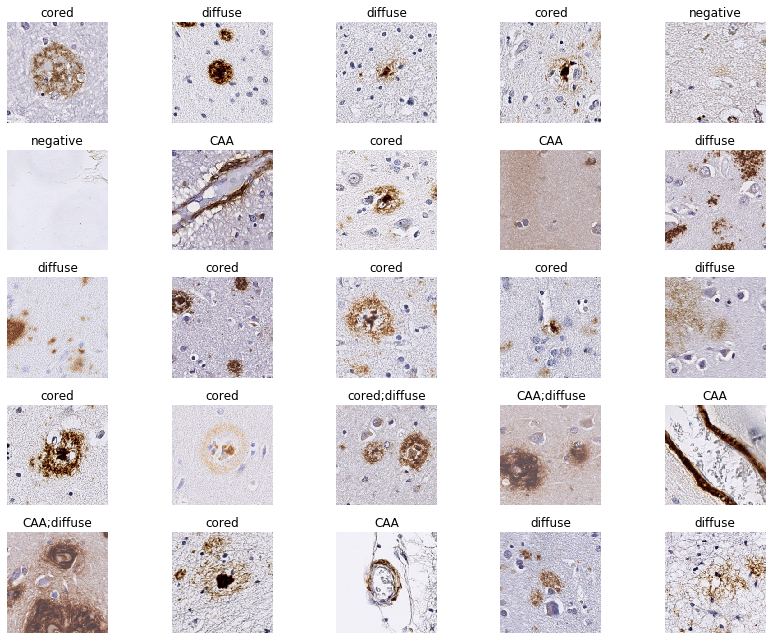

In [27]:
data.show_batch(rows=5, figsize=(12,9))

In [28]:
from fastai.callbacks.tracker import SaveModelCallback, EarlyStoppingCallback

class SaveModelCallbackToDest(SaveModelCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best to specific path."
    def __init__(self,
                 learn:Learner,
                 monitor:str='valid_loss',
                 mode:str='auto',
                 every:str='improvement',
                 name:str='bestmodel',
                 dest:str=None):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name, self.dest = every,name,dest
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
    
    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(os.path.join(self.dest, f'{self.name}_{epoch}'))
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(os.path.join(self.dest, f'{self.name}'))
                


In [29]:
resnet = models.resnet50

In [30]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)

In [31]:
learn = cnn_learner(data, resnet, metrics=[acc_05, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 53.8MB/s]


In [32]:
learn.data.classes

['CAA', 'cored', 'diffuse', 'negative']

In [33]:
learn = learn.to_fp16()
# This didn't speed up training?

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 2.51E-02


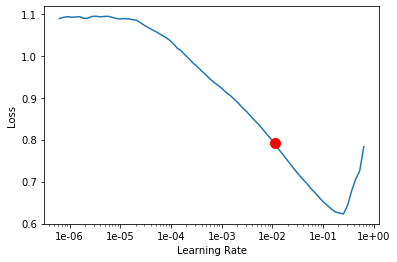

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.fit_one_cycle(10, slice(5e-02), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn50-stage1-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.154408,0.137237,0.948146,0.932904,04:01
1,0.148050,0.151226,0.946640,0.924916,04:00
2,0.147116,0.147844,0.949392,0.930146,04:00
3,0.136115,0.128085,0.965788,0.951365,04:00
4,0.123954,0.178071,0.942120,0.916252,03:59
5,0.110800,0.118327,0.962312,0.944237,03:58
6,0.098016,0.101775,0.965295,0.948714,03:59
7,0.085698,0.111248,0.961935,0.942464,03:58
8,0.075871,0.144582,0.960747,0.942411,03:57
9,0.075329,0.133447,0.961240,0.942916,03:56


Better model found at epoch 0 with valid_loss value: 0.13723739981651306.
Better model found at epoch 3 with valid_loss value: 0.12808534502983093.
Better model found at epoch 5 with valid_loss value: 0.11832660436630249.
Better model found at epoch 6 with valid_loss value: 0.10177535563707352.


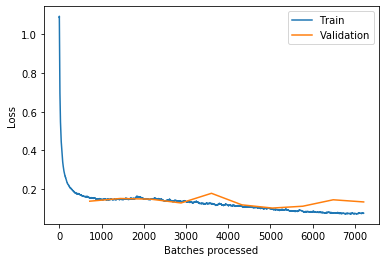

In [36]:
learn.recorder.plot_losses()

In [37]:
model_name = 'rn50-stage1-v1'
learn = learn.load(os.path.join(cfg.models_dir, model_name))

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.31E-06


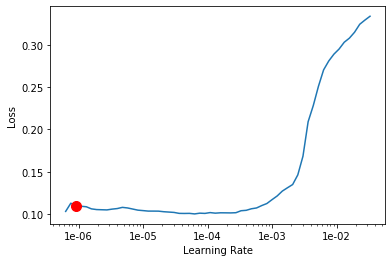

In [39]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(20, slice(1e-06, 5e-02/5), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn50-stage2-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086996,0.115690,0.960023,0.942876,04:51
1,0.079937,0.135546,0.954635,0.934811,04:50
2,0.079389,0.105916,0.965556,0.949100,04:50
3,0.080811,0.125461,0.957590,0.938024,04:49
4,0.075238,0.127362,0.958517,0.942665,04:49
5,0.071028,0.120941,0.962630,0.945622,04:50
6,0.062589,0.107435,0.966251,0.950484,04:50
7,0.057433,0.094752,0.971900,0.956339,04:49
8,0.052285,0.123421,0.958024,0.941684,04:50
9,0.047870,0.130196,0.957822,0.934541,04:50


Better model found at epoch 0 with valid_loss value: 0.11568968743085861.
Better model found at epoch 2 with valid_loss value: 0.10591563582420349.
Better model found at epoch 7 with valid_loss value: 0.09475173056125641.


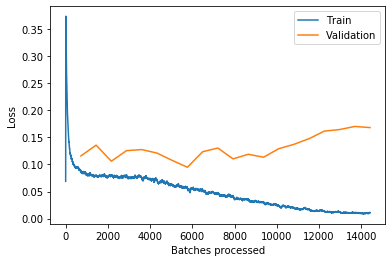

In [41]:
learn.recorder.plot_losses()

In [42]:
learn.save(os.path.join(cfg.models_dir, 'rn50-stage2-v1-20-epochs'))

In [ ]:
!sudo shutdown -h now